In [187]:
using AlgebraicPetri, DataFrames, DifferentialEquations, ModelingToolkit, Symbolics, EasyModelAnalysis, Catlab, Catlab.CategoricalAlgebra, JSON3, UnPack, Downloads, URIs, CSV, MathML, NLopt, Plots, StatsPlots, OptimizationBBO
@info "usings"
MTK = ModelingToolkit
EMA = EasyModelAnalysis
meqs = MTK.equations
dd = "/Users/anand/.julia/dev/EasyModelAnalysis/data"

┌ Info: usings
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo.ipynb:2


"/Users/anand/.julia/dev/EasyModelAnalysis/data"

In [131]:
include("demo_functions.jl")

build_weighted_ensemble_df (generic function with 1 method)

1. Upload a ground-truth dataset and its documentation via a URL
    * https://github.com/reichlab/covid19-forecast-hub/blob/master/data-truth/truth-Incident%20Hospitalizations.csv
    * https://github.com/reichlab/covid19-forecast-hub/blob/master/data-truth/README.md 

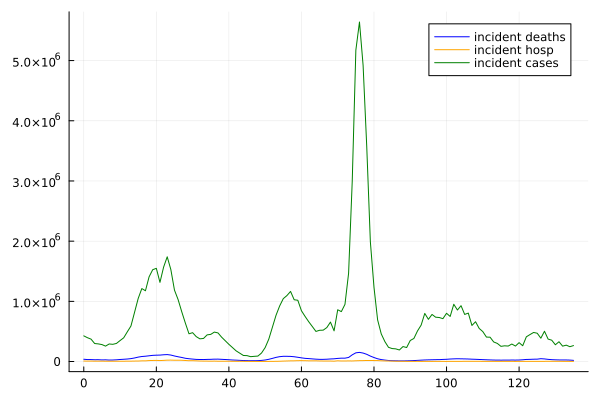

In [132]:
df, dfc, dfd, dfh, covidhub = get_dataframes()
plot_covidhub(df)

2. Split the dataset into a list of sub-datasets covering time periods of interest (in weeks)
    * select_timeperiods(df::DataFrame)::Vector{DataFrame}}


In [133]:
N_weeks = 20; period_step = 10; train_weeks=10
all_ts = df.t
dfs = select_timeperiods(df, N_weeks; step=period_step)
split_dfs = [train_test_split(df; train_weeks=train_weeks) for df in dfs]
train_dfs, test_dfs = unzip(split_dfs)

(DataFrame[10×4 DataFrame
 Row │ t      cases   deaths  hosp  
     │ Int64  Int64   Int64   Int64 
─────┼──────────────────────────────
   1 │     0  426504   38039   7823
   2 │     1  396061   32638   7369
   3 │     2  372155   32164   7097
   4 │     3  299096   29605   6046
   5 │     4  292841   30061   6228
   6 │     5  281799   26604   5821
   7 │     6  256026   28030   5071
   8 │     7  291617   24191   5275
   9 │     8  286018   25358   5347
  10 │     9  300436   28491   4953, 10×4 DataFrame
 Row │ t      cases    deaths  hosp  
     │ Int64  Int64    Int64   Int64 
─────┼───────────────────────────────
   1 │    10   348113   33744   5113
   2 │    11   394038   37562   5144
   3 │    12   493557   41729   5863
   4 │    13   589923   48331   6133
   5 │    14   818658   59224   7558
   6 │    15  1048060   73406   8317
   7 │    16  1212395   83419  11241
   8 │    17  1175780   88260  11034
   9 │    18  1406989   95431  16127
  10 │    19  1525551  102441  17509, 10

### Loading the Petri nets for our ensemble and converting them to ODESystems

In [134]:
petris, syss, defs = load_ensemble()
all_syms = [sys_syms(sys) for sys in syss]


3-element Vector{Vector{Any}}:
 [Susceptible(t), Infected(t), Diagnosed(t), Ailing(t), Recognized(t), Healed(t), Threatened(t), Extinct(t), t1, t2  …  tau, delta, lambda, beta, eta, kappa, nu, epsilon, theta, sigma]
 [Susceptible(t), Exposed(t), Infectious(t), Asymptomatic(t), Hospitalized(t), Recovered(t), Deceased(t), t1, t2, t3  …  ModelValue_125, ModelValue_120, ModelValue_18, ModelValue_135, ModelValue_17, ModelValue_124, beta_1_USA, l_1_USA, ModelValue_5, ModelValue_13]
 [Susceptible_unconfined(t), Exposed(t), Infected_reported(t), Infected_unreported(t), Quarantined(t), Recovered(t), Deceased(t), t1, t2, t3  …  mu, h, q, lambda, f, beta, eta_u, eta_r, sigma, theta]

### Adjust all model defaults to be standardized to population, not proportion of population, then convert to simulatable ODEProblems

In [135]:
# adjust the defaults to be in terms of the total population. now all 3 models have defaults in terms of pop
# this is a weak link in the workflow
# TODO: scale the outputs for loss instead of the u0
total_pop = 30_000_000

global opt_step_count = 0
for i in 1:2 # only the first two are in proportions 
    for st in states(syss[i])
        defs[i][st] *= total_pop # this mutates the return of ModelingToolkit.defaults
    end
end

In [136]:
observed.(syss)

3-element Vector{Vector{Equation}}:
 [Deaths(t) ~ Extinct(t), Hospitalizations(t) ~ Recognized(t) + Threatened(t), Cases(t) ~ Diagnosed(t) + Hospitalizations(t)]
 [Cases(t) ~ Infectious(t), Hospitalizations(t) ~ Hospitalized(t), Deaths(t) ~ Deceased(t)]
 [Cases(t) ~ Infected_reported(t), Deaths(t) ~ Deceased(t), Hospitalizations(t) ~ h*Infected_reported(t)]

3. Generate model-model and model-dataset alignment/map during structural comparisons
    * e.g. {("model0.S", "model1.s", ...):  "dataset.feature0", ...} 
    * V{Tuple{V{State/Obs}, Symbol}}. Hosp, cases, 


Since the MiraNet schema encodes the observables (Cases, Deaths, Hospitalizations) uniformly through all models in the ensemble, we only need to provide a single list of Model observable => column name

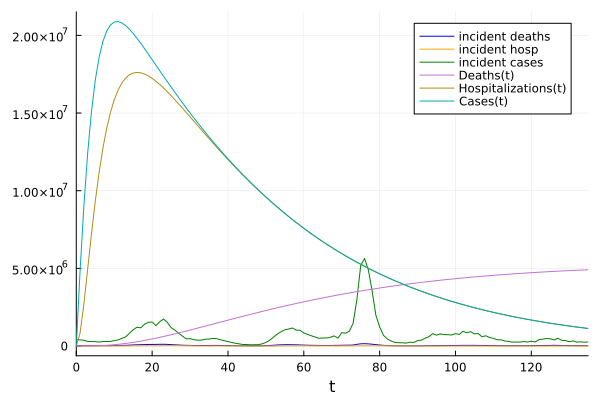

In [173]:
sys = syss[1]
syms = all_syms[1]

@unpack Deaths, Hospitalizations, Cases = sys
obs_sts = [Deaths, Hospitalizations, Cases]
mapping = Dict([Deaths => :deaths, Cases => :cases, Hospitalizations => :hosp])

prob = ODEProblem(sys, defs[1], extrema(all_ts), defs[1])
sol = solve(prob;saveat=all_ts)
plt = plot_covidhub(df)
plot!(plt, sol; idxs=obs_sts)

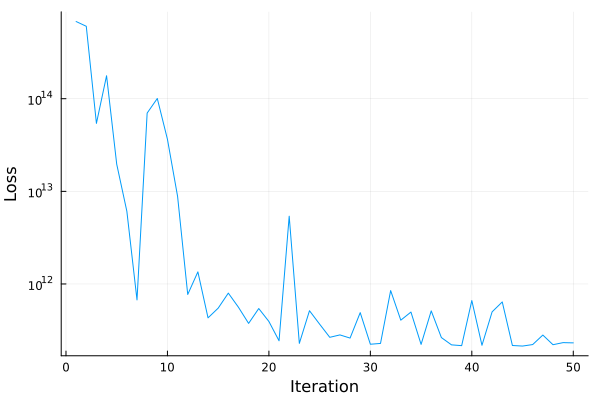

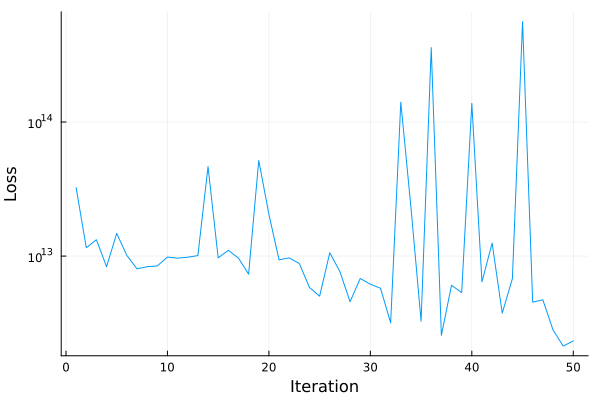

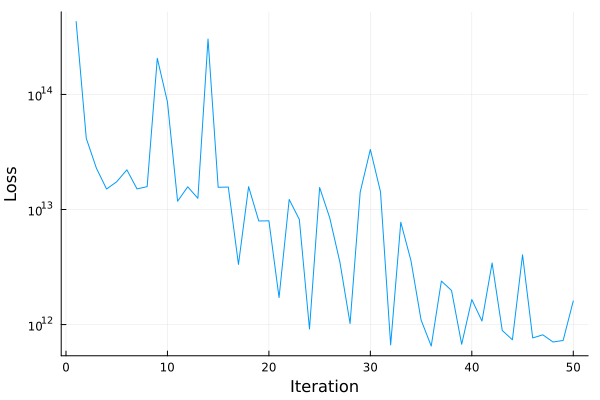

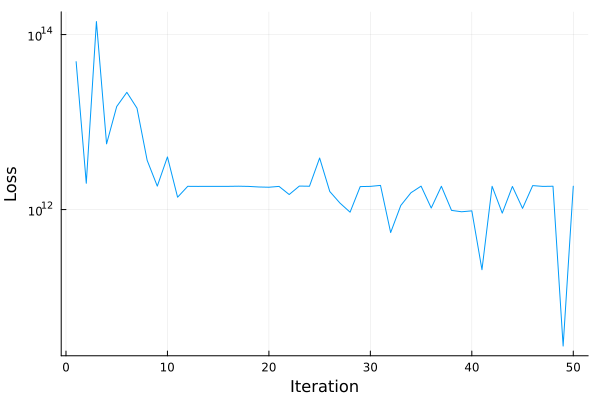

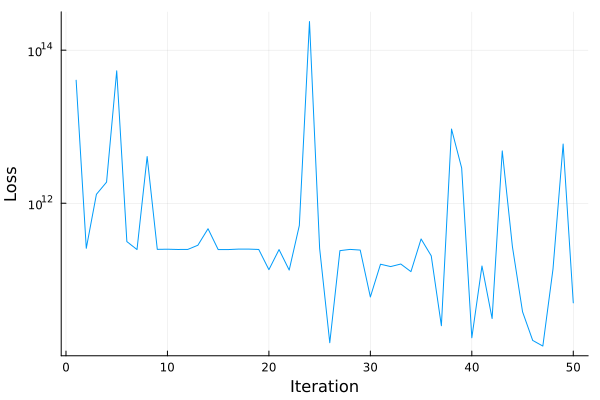

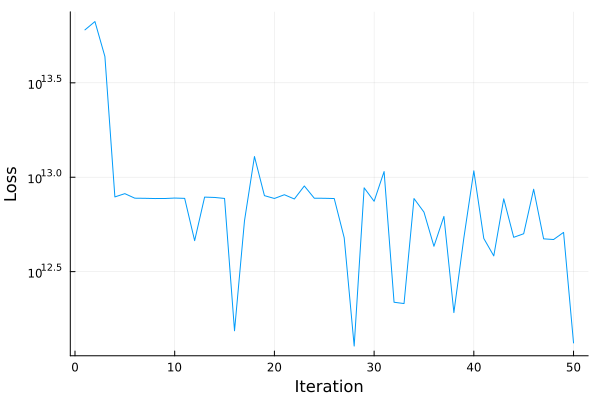

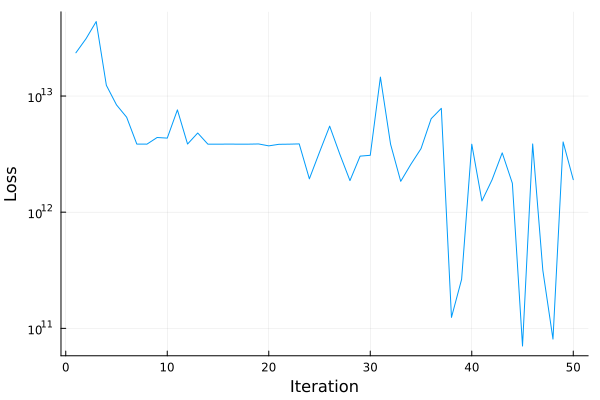

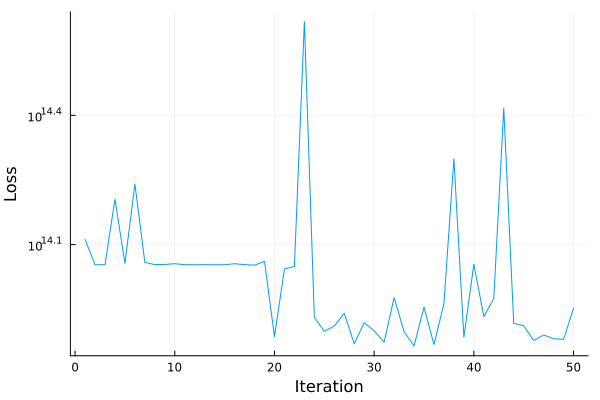

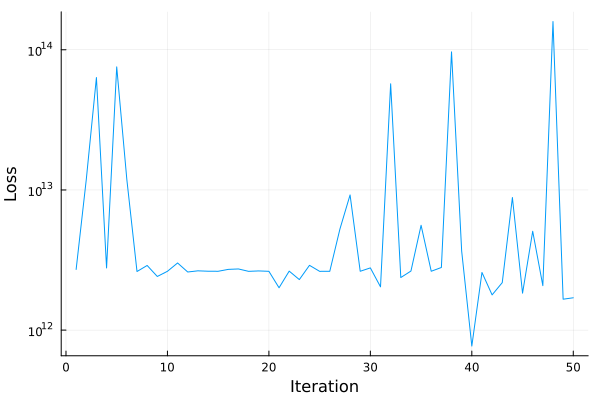

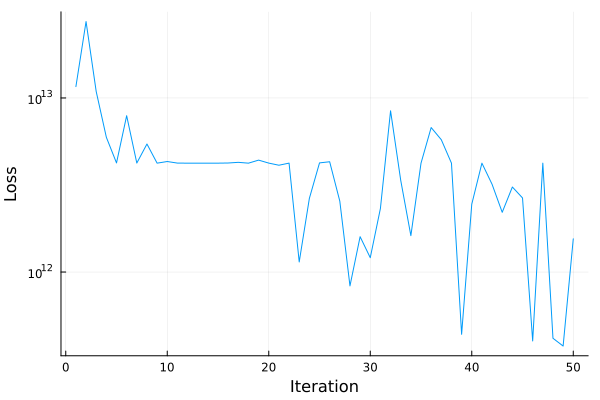

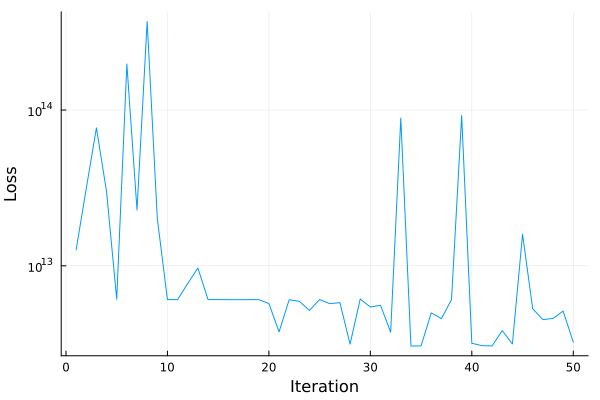

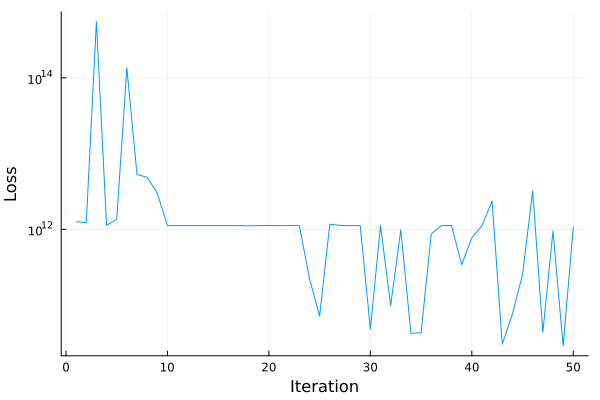

In [174]:
single_model_fits = global_ensemble_fit([prob], train_dfs, mapping; maxiters=5000, doplot=true);

4. Build an ensemble model using a list of the above models and alignment/map.
    * build_ensemble_model(Tuple{Vector<ODESystem>, typeof(3)})::EnsembleProblem | Vector{ODEProblem}


In [188]:
# TODO: to separate into train and test losses, i need to simulate train up until t0 of test, remake with that u0, then forecast for the test period
losses, remade_probs, remade_solutions = calculate_losses_and_solutions(single_model_fits, [prob], dfs);
fitdf = fitvec_to_df(single_model_fits[1], syms)

12×40 DataFrame
 Row │ Susceptible     Infected   Diagnosed      Ailing     Recognized  Healed ⋯
     │ Float64         Float64    Float64        Float64    Float64     Float6 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │      3.29554e7  4.22862e7      8.67981e7  3.42156e7   7.45822e7  4.3761 ⋯
   2 │ 134100.0        5.98656e7      8.11903e7  2.58788e7   8.83172e7  2.6596
   3 │      2.68207e7  7.41809e7      8.50005e7  8.19176e7   8.2403e7   4.8630
   4 │      8.91628e7  4.04088e7      2.28066e7  6.11345e7   1.77779e7  9.4394
   5 │      4.49632e7  4.95259e7      7.86036e7  3.56803e7   6.63578e7  8.6372 ⋯
   6 │      4.96229e7  2.62915e7      3.96602e7  9.35054e6   6.26416e7  7.2278
   7 │      1.84808e7  7.01818e7      4.54188e7  4.1066e7    6.86158e7  7.3743
   8 │      4.86975e7  7.09529e7      3.70563e7  1.43441e7   8.57204e7  8.0484
   9 │      3.98845e6  8.84595e7  30696.4        2.03029e7   1.71226e7  8.0160 ⋯
  10 │      4.62818e6  7.89047e7      1.66371e7  5.83076e7   4.75755e7  9.1394
  11 │      8.95352e7  7.186e7        7.68854e7  7.03284e7   7.24782e5  6.5183
  12 │      9.79764e6  8.28303e7      6.01594e7  7.45871e7   4.10852e7  6.2651
                                                              35 columns omitted

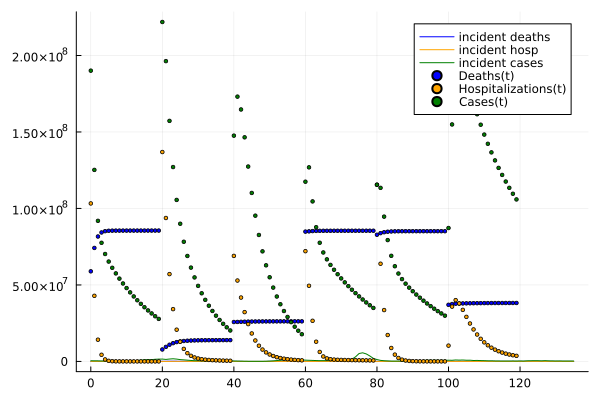

In [189]:
plt = forecast_plot(df, remade_solutions[1][1:2:end])

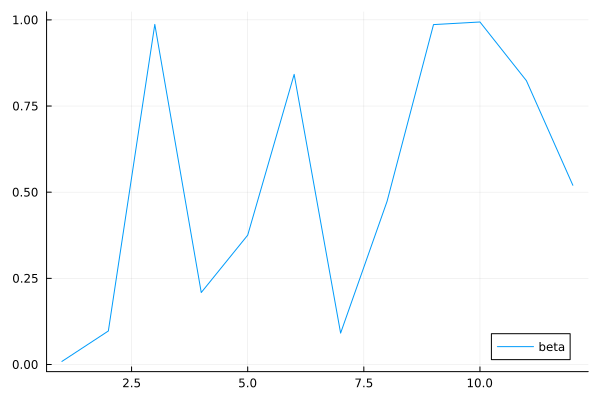

In [140]:
# plot how beta was fit for each timeperiod for model 1
plot(fitdf.beta; label="beta", xaxis="timeperiod")

5. Build and run an ensemble calibration simulator 
    * Select the list of split ground-truth sub-datasets as training-test datasets
    * Select the ensemble model as the input model
    * Select the alignment/map
    * Specify the ensemble calibration mode (no-training-equal-weights, separate-model-weight training, joint model-weight training)
    * Specify the train-validate-test ratio, cross-validation mode, loss function, early-stop condition, etc.
    * ensemble_calibrate_separate(typeof(4), typeof(2)[1][1]; optimization_options)::V<(calibrationmap,loss,weights)>
    * Total 1-4. train 1-2, test 3-4. Trainloss = l2(1-2), testloss = l2(3-4)  


In [141]:
# now multiple models 
odeprobs = [ODEProblem(sys, [], extrema(all_ts)) for sys in syss];
ensemble_fits = global_ensemble_fit(odeprobs, train_dfs, mapping; maxiters=2000, doplot=false) # 2000 for speed, the API can parallelize, so I won't do it here
ensemble_losses, ensemble_remade_probs, ensemble_sols = calculate_losses_and_solutions(ensemble_fits, odeprobs, dfs);
fitdfs = [fitvec_to_df(fit, all_syms[i]) for (i, fit) in enumerate(ensemble_fits)]

3-element Vector{DataFrame}:
 12×40 DataFrame
 Row │ Susceptible  Infected   Diagnosed  Ailing     Recognized  Healed     Th ⋯
     │ Float64      Float64    Float64    Float64    Float64     Float64    Fl ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │   1.843e6    8.80614e7  2.99508e7  3.48569e7   2.82459e7  6.15796e6   8 ⋯
   2 │   8.87859e7  9.09391e7  8.26184e7  3.74456e7   8.95049e7  2.46271e5   6
   3 │   2.59112e7  8.11885e7  9.051e6    3.64281e7   7.54362e7  3.35043e7   4
   4 │   2.08e7     1.55177e7  5.83911e7  9.4028e7    2.45506e7  9.44997e6   1
   5 │   1.55117e7  7.91672e7  2.62225e7  4.38007e7   8.09457e6  1.59293e7   9 ⋯
   6 │   4.62461e7  8.76476e7  9.41089e7  6.53598e7   9.67254e7  8.62924e7   4
   7 │   9.5376e7   6.62296e7  9.38652e7  2.96065e7   9.59494e7  5.24335e7   9
   8 │   8.38786e7  8.19167e7  4.08962e7  8.45249e7   6.86167e7  4.86919e7   3
   9 │   7.80934e7  8.83256e7  5.00242e7  9.83067e7   6.32755e7  3.23033e7 

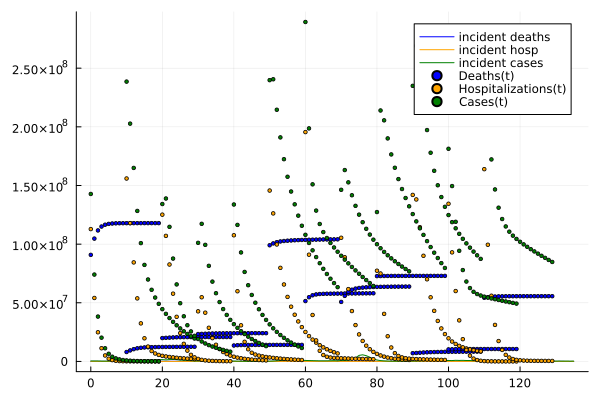

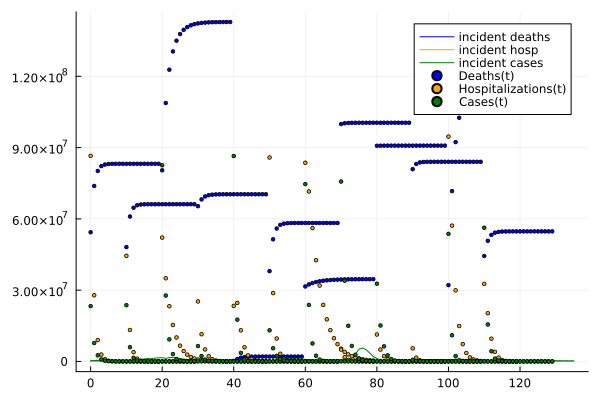

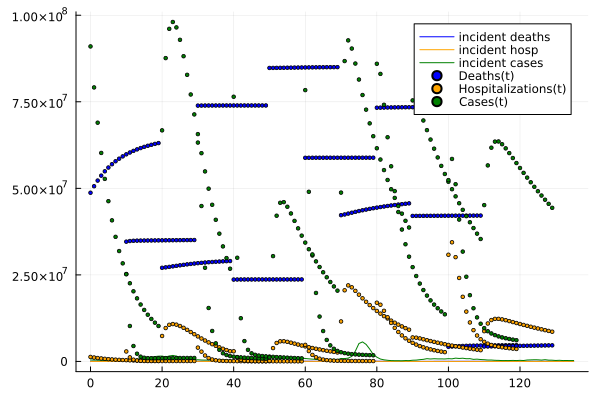

In [154]:
forecast_plts = [forecast_plot(df, ensemble_sol) for ensemble_sol in ensemble_sols]
display.(forecast_plts);

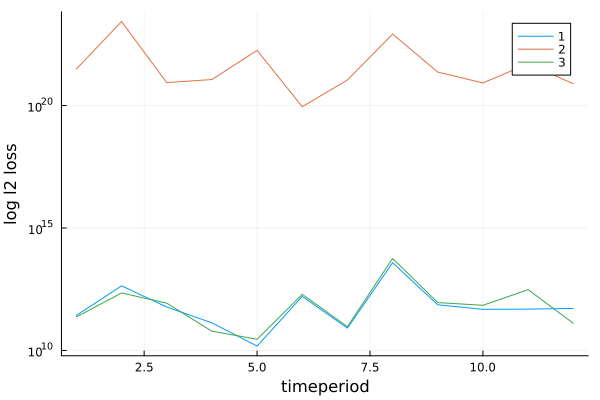

In [143]:
# this plot shows that the second model consistently underperforms 
ensemble_loss_plot(losses)

In [144]:
dfi = dfs[1]
prbs = ensemble_remade_probs[:, 1]
# optimize linear conbination weights for the ensemble for first timeperiod
weights = optimize_ensemble_weights(prbs, dfi.t, Matrix(dfi[:, 2:end]); maxiters=1000)

u: 3-element Vector{Float64}:
 0.0017255699297669728
 0.0036421218440939322
 0.0014098391216699922

In [179]:
# interface for solving collections of models at a time, used to do the second phase of optimization
eprob = EnsembleProblem(prbs; prob_func=(probs, i, reset) -> probs[i])
esol = solve(eprob; trajectories=length(prbs), saveat=dfi.t)
esol[obs_sts] # we can index into the ensemble

3-element Vector{Vector{Vector{Float64}}}:
 [[9.085121844854209e7, 1.1282358718232147e8, 1.4277440035822436e8], [1.0472264859305404e8, 5.409876297867355e7, 7.405937731783915e7], [1.1168273689926234e8, 2.486447085358743e7, 3.82432252739088e7], [1.1500827120140341e8, 1.123776209155629e7, 2.0265104025748566e7], [1.1655273905227587e8, 5.077644092335331e6, 1.121588065265333e7], [1.1726162582648183e8, 2.3252595929558845e6, 6.53500708536514e6], [1.1758736612839521e8, 1.0969784377439483e6, 4.011872940391536e6], [1.1773966528985785e8, 543241.140086521, 2.5826575924549634e6], [1.1781352791269842e8, 287742.5281070625, 1.7303661504202136e6], [1.1785140719026074e8, 165466.94538991986, 1.1977565083135036e6], [1.1787236982844421e8, 103592.16621793289, 850989.9133912385], [1.178850204448207e8, 69893.67231011037, 617370.9428134467], [1.1789330883604573e8, 49958.79377932563, 455578.93491216644], [1.1789912337154342e8, 37153.525656747544, 340846.17098173953], [1.1790339502621908e8, 28379.909890068666, 25

6. Assess consistency of the ensemble by tracking the smoothness/continuity of the ensemble weights across the time periods of interest. (plots from page 1, and bar plot)

In [157]:
# this recreates the covidhub df from the weighted ensemble
weighted_ensemble_df = build_weighted_ensemble_df(weights, esol)

20×4 DataFrame
 Row │ t      deaths          hosp           cases         
     │ Int64  Float64         Float64        Float64       
─────┼─────────────────────────────────────────────────────
   1 │     0       4.23469e5      5.11638e5      4.59395e5
   2 │     1       5.21039e5      1.96344e5      2.67571e5
   3 │     2       5.58321e5  76975.2            1.72578e5
   4 │     3       5.73504e5  31169.5            1.2298e5
   5 │     4       5.80339e5  13249.0        94717.4
   6 │     5       5.83889e5   6056.94       76875.5
   7 │     6       5.86062e5   3075.66       64492.7
   8 │     7       5.87603e5   1779.94       55235.0
  ⋮  │   ⋮          ⋮               ⋮              ⋮
  14 │    13       5.92758e5    430.703      26273.3
  15 │    14  593305.0          379.64       23619.5
  16 │    15       5.93798e5    337.193      21309.1
  17 │    16       5.94245e5    301.268      19287.4
  18 │    17       5.94649e5    270.495      17510.8
  19 │    18       5.95018e5    243.904      15943.2
  20 │    19       5.95354e5    220.764      14554.2
                                             5 rows omitted

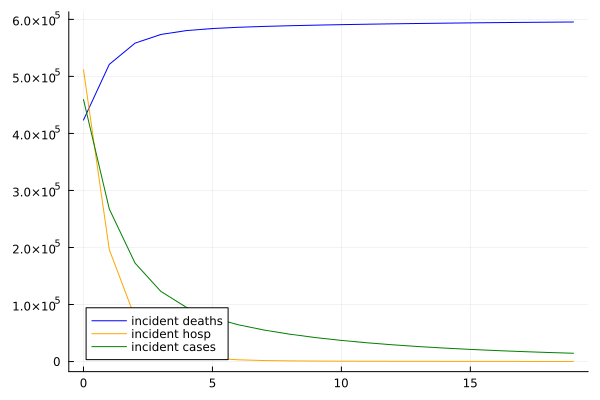

In [158]:
display(plot_covidhub(weighted_ensemble_df))

In [146]:
# this optimizes the weights for all timeperiods, returning a dataframe for the optimized weight for each model for each timeperiod
weights_df = build_all_weights_df(ensemble_remade_probs, dfs)

12×3 DataFrame
 Row │ x1           x2          x3          
     │ Float64      Float64     Float64     
─────┼──────────────────────────────────────
   1 │ 0.000512597  0.00507719  0.000147298
   2 │ 0.00110295   0.0135721   0.00319437
   3 │ 0.00023115   0.00552495  0.00152181
   4 │ 0.000233292  0.00317291  2.31565e-5
   5 │ 0.000959789  2.0357e-5   0.00933472
   6 │ 0.000750825  0.00748565  0.000713771
   7 │ 0.000631174  0.0049222   0.0196313
   8 │ 4.08624e-5   0.0150164   0.00205309
   9 │ 1.96381e-5   0.00843298  0.00428194
  10 │ 0.0014829    0.00343547  0.00231489
  11 │ 0.000759428  0.00365295  0.00675476
  12 │ 8.78728e-5   0.00414787  0.00051289

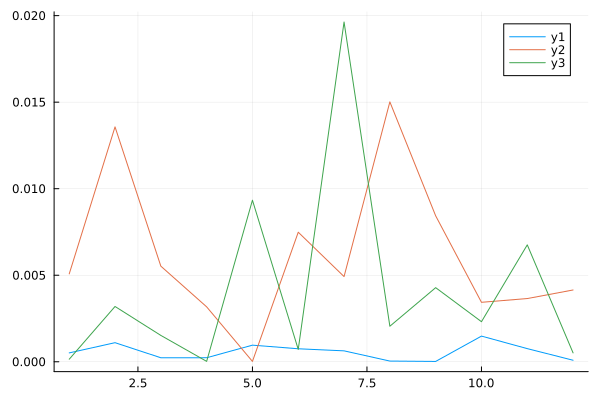

In [147]:
# see if the weights are consistent over time (which is consistent with ensemble_loss_plot(losses) above)
plt = plot(;xaxis="timeperiod")
plot!(plt, weights_df.x1; label="model 1 weight");
plot!(plt, weights_df.x2 label="model 2 weight");
plot!(plt, weights_df.x3 label="model 3 weight");
display(plt)

7. Build and run a forecast simulator
    * Select the alignment/map from 
    * Select the ensemble model from 
    * Select the calibrated parameter output from 
    * Select the time points of the forecast horizon 
    * forecast(calibrated 4, df), forecast(4, df, calibrationmap)
    * ensemble_forecast(4, df, map, weights)


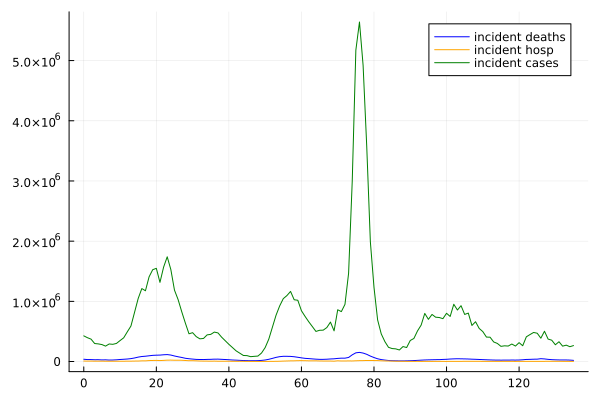

In [169]:
plot_covidhub(df)

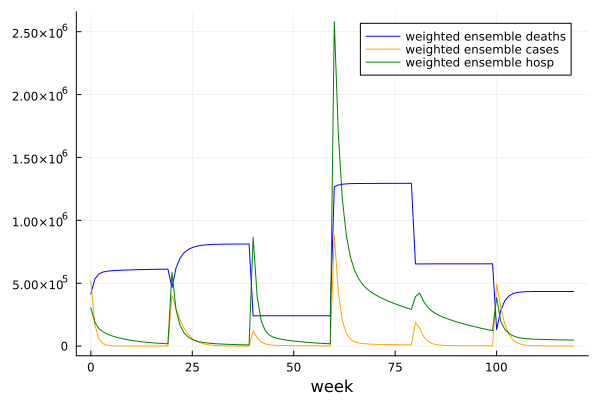

In [186]:
# plot the weighted ensemble stitched together into a covidhub df
include("demo_functions.jl")
xx = stitched_ensemble_df(ensemble_remade_probs, dfs);
plt = plot_covidhub(reduce(vcat, xx[1:2:end]);labs=["weighted ensemble deaths", "weighted ensemble cases", "weighted ensemble hosp"]);
xaxis!("week")
